Assignment on Graph Neural Networks in the course Advanced machine learning using neural networks (Chalmers and University of Gothenburg).

The objective is to train a GNN that works as a graph classifier on the provided data. The data comes from simulations of a 25 qubit quantum memory (surface code) with individual error rates of 5% per cycle of measurements (see assignment text for a little more detail). Since the data consists of graphs with varying number of nodes the way to implement the classifier is to make a graph embedding, i.e. a mapping of each graph to a vector of fixed size. This can then be used for classification. The typical structure would be Graph data-> Graph (convolution or other) layers -> Pooling -> Dense classifier.

For this data the classification accuracy of the standard graph algorithm based decoder (minimum weight perfect matching) is 0.983. It may be hard to reach this without an even larger dataset, but it can serve as a target. Anything above an accuracy of 0.95 is acceptable. (This means that the quantum memory has a lower failure rate than the individual qubits, which is set at 5% to generate the data.)

In [7]:
import os
import torch
os.environ['TORCH'] = torch.__version__
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

Some suggested GNN layers, you're welcome to try other.   

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
import networkx as nx
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool, GraphConv, GATConv, GCNConv

%config InlineBackend.figure_format = 'svg'

The following shows how to load the data if it's available in your Google drive

In [9]:
#If the data is available in your Google drive:
# from google.colab import drive
# drive.mount('/content/drive')

In [25]:
#It's a quite big dataset, so may take a few minutes
dataset_path = r"C:\Users\purus\Documents\Chalmers\Advanced_ML\HW1\Quantum_memory\graph_data_decoding_2024.pt"
# dataset = torch.load(dataset_path)
dataset = torch.load(dataset_path, map_location=torch.device('cpu'))

Properties of the graphs

In [11]:
print('=============================================================')
print(f'Number of graphs: {len(dataset)}')
print('=============================================================')
data = dataset[7]  # Get one data point.

print('Some properties of a graph in the dataset:')
print()

print(data)
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Number of node features: {data.num_node_features}')
print(data.batch)



Number of graphs: 1000000
Some properties of a graph in the dataset:

Data(x=[8, 4], edge_index=[2, 52], edge_attr=[52, 1], y=[1, 2])
Number of nodes: 8
Number of edges: 52
Average node degree: 6.50
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of node features: 4
None


Note that the label y, is given by a tensor with 2 elements, giving a binary representation of the predicted equivalence class.  

*   00 <-> class I
*   10 <-> class X
*   01 <-> class Z
*   11 <-> class Y

The loss can either be constructed using two spearate classifiers, one for X and one for Z, or combined into one over all four classes. Either should work.



In [ ]:
label=data.y
label_X=label[:,0]
label_Z=label[:,1]
print(label_X,label_Z)
#The data point dataset[20] is thus in class X

tensor([0.]) tensor([0.])


The data consists of 4-dimensional feature vector per node, and each edge comes with a scalar weight.   

In [ ]:
edge_index = data.edge_index.t()
edge_index=edge_index.numpy()
feature=data.x.numpy()
edge=data.edge_attr.numpy()
# print(len(edge_index))
# print(edge_index[0])
# print(edge)
# print(feature)

In [ ]:
graph = dataset[7]
g = utils.to_networkx(graph, to_undirected=True)
positions = {}
label_positions = {}
node_labels = {}
edge_labels={}
x = graph.x
for i in range(x.shape[0]):
    positions[i] = np.array([x[i, 2], x[i, 3]])
    label_positions[i] = np.array([x[i, 2], x[i, 3]])
    node_labels[i] = np.array([x[i, 0], x[i, 1], x[i, 2], x[i, 3]])
for i in range(edge_index.shape[0]):
    edge_labels[(edge_index[i,0],edge_index[i,1])]=edge[i]

(0.11600000247359277,
 1.0840000005066395,
 0.11600000247359277,
 1.0840000005066395)

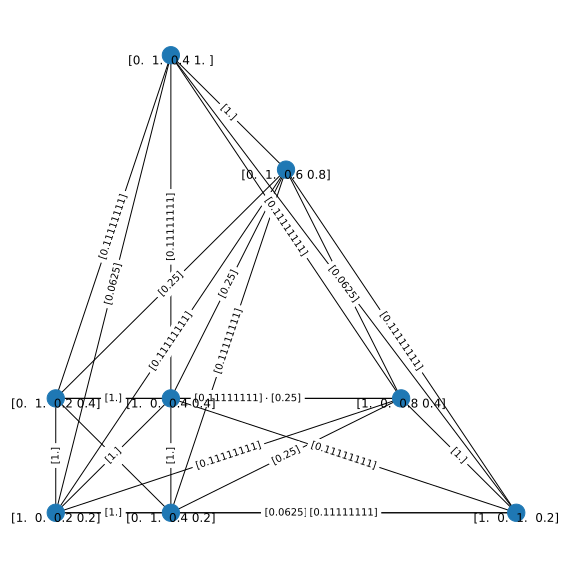

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
nx.draw_networkx(g, ax=ax, pos = positions, labels = node_labels, with_labels = False)
nx.draw_networkx_labels(g, ax=ax, pos = label_positions, labels = node_labels, verticalalignment= 'top')
nx.draw_networkx_edge_labels(g,ax=ax,  pos = positions,edge_labels=edge_labels)
ax.axis('off')

In [13]:
# split the dataset into test and validation:
num_samples = len(dataset)
train_data = dataset[int(.05 * num_samples ) :] # 95% train
test_data = dataset[: int(.05 * num_samples )] # 5% test
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)


for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 1000
DataBatch(x=[3346, 4], edge_index=[2, 11320], edge_attr=[11320, 1], y=[1000, 2], batch=[3346], ptr=[1001])

Step 2:
Number of graphs in the current batch: 1000
DataBatch(x=[3474, 4], edge_index=[2, 11932], edge_attr=[11932, 1], y=[1000, 2], batch=[3474], ptr=[1001])

Step 3:
Number of graphs in the current batch: 1000
DataBatch(x=[3300, 4], edge_index=[2, 10728], edge_attr=[10728, 1], y=[1000, 2], batch=[3300], ptr=[1001])

Step 4:
Number of graphs in the current batch: 1000
DataBatch(x=[3370, 4], edge_index=[2, 11346], edge_attr=[11346, 1], y=[1000, 2], batch=[3370], ptr=[1001])

Step 5:
Number of graphs in the current batch: 1000
DataBatch(x=[3367, 4], edge_index=[2, 11258], edge_attr=[11258, 1], y=[1000, 2], batch=[3367], ptr=[1001])

Step 6:
Number of graphs in the current batch: 1000
DataBatch(x=[3350, 4], edge_index=[2, 11318], edge_attr=[11318, 1], y=[1000, 2], batch=[3350], ptr=[1001])

Step 7:
Number of graphs in the current 

In [17]:
print(data.batch)
print(data.edge_index)
print(data.edge_attr)

tensor([  0,   0,   0,  ..., 999, 999, 999])
tensor([[   0,    0,    1,  ..., 3449, 3449, 3449],
        [   1,    2,    0,  ..., 3446, 3447, 3448]])
tensor([[1.0000],
        [0.2500],
        [1.0000],
        ...,
        [0.2500],
        [1.0000],
        [0.2500]])


In [11]:
import torch

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345) 
        self.conv1 = GraphConv(data.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 4)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer to embeeded graph
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)
model = GCN(hidden_channels=30).to(device)
print(model)

True
cuda
GCN(
  (conv1): GraphConv(4, 30)
  (conv2): GraphConv(30, 30)
  (conv3): GraphConv(30, 30)
  (lin): Linear(in_features=30, out_features=4, bias=True)
)


In [22]:
import torch

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345) 
        self.conv1 = GraphConv(data.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 4)

    def forward(self, x, edge_index,edge_weight=None, batch=None):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index,edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index,edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index,edge_weight)

        # 2. Readout layer to embeeded graph
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)
model = GCN(hidden_channels=30).to(device)
print(model)

True
cuda
GCN(
  (conv1): GraphConv(4, 30)
  (conv2): GraphConv(30, 30)
  (conv3): GraphConv(30, 30)
  (lin): Linear(in_features=30, out_features=4, bias=True)
)


In [23]:
import torch.nn.functional as F

model = GCN(hidden_channels=30)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(data.y[0]==[0,0])
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        #  data = data.to(device)
         out = model(data.x, data.edge_index, data.edge_attr, data.batch)  # Perform a single forward pass.
        #  loss = criterion(out, data.y)  # Compute the loss.
         targets_one_hot = torch.zeros_like(out)
         y_duplicate=torch.zeros(len(data.y))
        #  for i in range(len(data.y)):
        #     if data.y[i]== [0, 0]:
        #          y_duplicate[i]=0
        #     elif data.y[i] == [1,0]:
        #         y_duplicate[i]==1
        #     elif data.y[i]==[0,1]:
        #         y_duplicate[i]==2
        #     elif data.y[i]==[1,1]:
        #         y_duplicate[i]=3
        # Convert data.y to a tensor
         

        # Compute integer label based on binary representation
         y_duplicate = data.y[:, 0] * 2 + data.y[:, 1]


                  
         targets_one_hot.scatter_(1, y_duplicate.view(-1, 1).long(), 1)

         loss = F.binary_cross_entropy_with_logits(out, targets_one_hot)

        
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
        #  data = data.to(device)
         out = model(data.x, data.edge_index, data.edge_attr, data.batch)
         
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         y_duplicate = data.y[:, 0] * 2 + data.y[:, 1]
         correct += int((pred == y_duplicate).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

train_acc_list=[]
test_acc_list=[]
for epoch in range(1, 20):
    train()

    train_acc = test(train_loader)
    train_acc_list.append(train_acc)
    test_acc = test(test_loader)
    test_acc_list.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')




False
Epoch: 001, Train Acc: 0.9546, Test Acc: 0.9543
Epoch: 002, Train Acc: 0.9605, Test Acc: 0.9608
Epoch: 003, Train Acc: 0.9617, Test Acc: 0.9613
Epoch: 004, Train Acc: 0.9633, Test Acc: 0.9638
Epoch: 005, Train Acc: 0.9639, Test Acc: 0.9641
Epoch: 006, Train Acc: 0.9642, Test Acc: 0.9642
Epoch: 007, Train Acc: 0.9651, Test Acc: 0.9653
Epoch: 008, Train Acc: 0.9653, Test Acc: 0.9649
Epoch: 009, Train Acc: 0.9663, Test Acc: 0.9665
Epoch: 010, Train Acc: 0.9652, Test Acc: 0.9651
Epoch: 011, Train Acc: 0.9669, Test Acc: 0.9666
Epoch: 012, Train Acc: 0.9667, Test Acc: 0.9671
Epoch: 013, Train Acc: 0.9672, Test Acc: 0.9673
Epoch: 014, Train Acc: 0.9674, Test Acc: 0.9672
Epoch: 015, Train Acc: 0.9677, Test Acc: 0.9679
Epoch: 016, Train Acc: 0.9674, Test Acc: 0.9675
Epoch: 017, Train Acc: 0.9676, Test Acc: 0.9674
Epoch: 018, Train Acc: 0.9687, Test Acc: 0.9693
Epoch: 019, Train Acc: 0.9681, Test Acc: 0.9684


'F.sigmoid + F.binary_cross_entropy'

pred = torch.sigmoid(x)

loss = F.binary_cross_entropy(pred, y)

loss

'F.binary_cross_entropy_with_logits'

F.binary_cross_entropy_with_logits(x, y)

both yeilds same answer

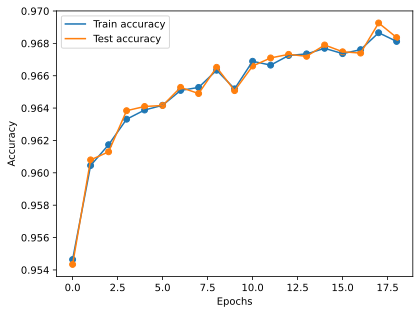

Test Accuracy: 0.9684


In [24]:
plt.plot(np.arange(0,19,1),train_acc_list,label='Train accuracy')
plt.scatter(np.arange(0,19,1),train_acc_list)

plt.plot(np.arange(0,19,1),test_acc_list,label='Test accuracy')
plt.scatter(np.arange(0,19,1),test_acc_list)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f'Test Accuracy: {test_acc_list[-1]:.4f}')

Let's break down the line `x = global_mean_pool(x, batch)` with an example and explain its purpose in the context of a graph neural network (GNN).
 
In a graph neural network, after passing node features through multiple layers (e.g., Graph Convolutional Layers), we often want to obtain a fixed-size representation for each graph in the batch. This fixed-size representation, often referred to as a graph-level representation or graph embedding, summarizes the information from all nodes in the graph and is crucial for tasks such as graph classification.

Here's what each component means in `global_mean_pool(x, batch)`:

- `x`: This represents the node embeddings or features obtained from the last layer of the GNN. Each row of `x` corresponds to the feature representation of a node in the graph. So, if you have a batch of graphs, `x` would be a tensor of shape `[total_num_nodes, embedding_dim]`.
  
- `batch`: This tensor indicates to which graph each node in `x` belongs. Each entry in `batch` corresponds to the index of the graph in the batch to which the corresponding node belongs. For instance, if `batch[i] == j`, it means that the i-th node in `x` belongs to the j-th graph in the batch.

- `global_mean_pool`: This function computes the mean (average) of node features across all nodes in each graph separately. It pools the node features within each graph in the batch and returns a tensor containing the mean-pooled graph-level representations.



- Graph 1: 4 nodes with features of dimension 3.
- Graph 2: 3 nodes with features of dimension 3.



```
x = tensor([[1.0, 2.0, 3.0],   # Node 1 in Graph 1
            [2.0, 3.0, 4.0],   # Node 2 in Graph 1
            [3.0, 4.0, 5.0],   # Node 3 in Graph 1
            [4.0, 5.0, 6.0],   # Node 4 in Graph 1
            [0.5, 1.0, 1.5],   # Node 1 in Graph 2
            [1.5, 2.0, 2.5],   # Node 2 in Graph 2
            [2.5, 3.0, 3.5]])  # Node 3 in Graph 2

batch = tensor([0, 0, 0, 0, 1, 1, 1])  # Batch tensor
```

After applying `global_mean_pool(x, batch)`, the function will compute the mean of node features separately for each graph in the batch. The output will be a tensor with a graph-level representation for each graph:

```
graph_level_representations = tensor([[2.5, 3.5, 4.5],   # Graph 1
                                      [1.5, 2.0, 2.5]])  # Graph 2
```

In this example, the feature vectors `[2.5, 3.5, 4.5]` represent the mean-pooled representation of Graph 1, and `[1.5, 2.0, 2.5]` represent the mean-pooled representation of Graph 2.

This operation effectively summarizes the information from all nodes in each graph into a fixed-size representation, which can then be used for downstream tasks such as graph classification or regression.

1. **Graph Classification Model (First Implementation)**:
   - Input: The input to the model consists of node features, edge indices, and batch information.
   - Operation:
     - The input node features are passed through multiple GCN layers (`GraphConv`), followed by a ReLU activation function.
     - The output of the GCN layers is then aggregated across all nodes in each graph using global pooling (`global_mean_pool`). This operation computes the mean of node features for each graph in the batch.
     - Finally, the aggregated graph representations are passed through a linear layer (`Linear`) to make predictions for each graph.
   - Mathematically:
     - Let X  represent the input node features,  A  represent the adjacency matrix, and  \mathbf{B} represent the batch information.
     - The output of each GCN layer is computed as$$  H^{(i)} = \sigma(\text{GCNConv}(H^{(i-1)}, A)) $$, where $$ H^{(0)} = X $$
     - After applying global pooling, the aggregated graph representations are computed as $$\text{Agg} = \text{global\_mean\_pool}(H^{(L)}, \mathbf{B})$$, where  L  is the number of GCN layers.
     - Finally, the output logits for graph classification are computed as $$ \text{Logits} = \text{Linear}(\text{Agg}) $$.

2. **Node Classification Model (Second Implementation)**:
   - Input: The input to the model consists of node features and edge indices.
   - Operation:
     - The input node features are passed through multiple GCN layers (`GCNConv`), followed by a ReLU activation function.
     - Each node representation is updated independently based on its local neighborhood.
     - Finally, the updated node representations are passed through a linear layer (`Linear`) to make predictions for each node.
   - Mathematically:
     - Let $$ X $$ represent the input node features and $$ A $$ represent the adjacency matrix.
     - The output of each GCN layer is computed as $$ H^{(i)} = \sigma(\text{GCNConv}(H^{(i-1)}, A)) $$, where $$ H^{(0)} = X $$.
     - The output logits for node classification are computed as $$ \text{Logits} = \text{Linear}(H^{(L)}) $$, where $$ L $$ is the number of GCN layers.

In summary, the key mathematical difference lies in how the model aggregates information and makes predictions:
- In graph classification, the model aggregates information across all nodes in each graph and makes predictions for the entire graph.
- In node classification, the model updates node representations independently based on their local neighborhoods and makes predictions for each individual node.

In [ ]:
import torch.nn.functional as F

def train():
    model.train()

    for data in train_loader:  # Iterate over the training dataset batches
        optimizer.zero_grad()  # Clear gradients
        out = model(data.x, data.edge_index, data.batch)  # Perform a forward pass
        
        # Convert ground truth labels to binary format
        target = torch.zeros(out.size(0), out.size(1), dtype=torch.float, device=out.device)  # Initialize target tensor
        index = data.y.repeat_interleave(data.num_nodes, dim=0).view(-1, 1).long()  # Repeat each label for all nodes in the batch
        target.scatter_(1, index, 1)  # Convert one-hot encoded labels to binary format
        
        # Compute Binary Cross-Entropy Loss
        loss = F.binary_cross_entropy_with_logits(out, target)  # Compute the loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate over the dataset batches
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Get the predicted classes
        correct += int((pred == data.y).sum())  # Count correct predictions
        
    return correct / len(loader.dataset)  # Calculate accuracy

for epoch in range(1, 2):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


RuntimeError: Expected index [6928000, 1] to be smaller than self [1000, 8] apart from dimension 1